In [12]:
import torch
import numpy as np
from spikingjelly.activation_based import neuron
from spikingjelly import visualizing
from matplotlib import pyplot as plt

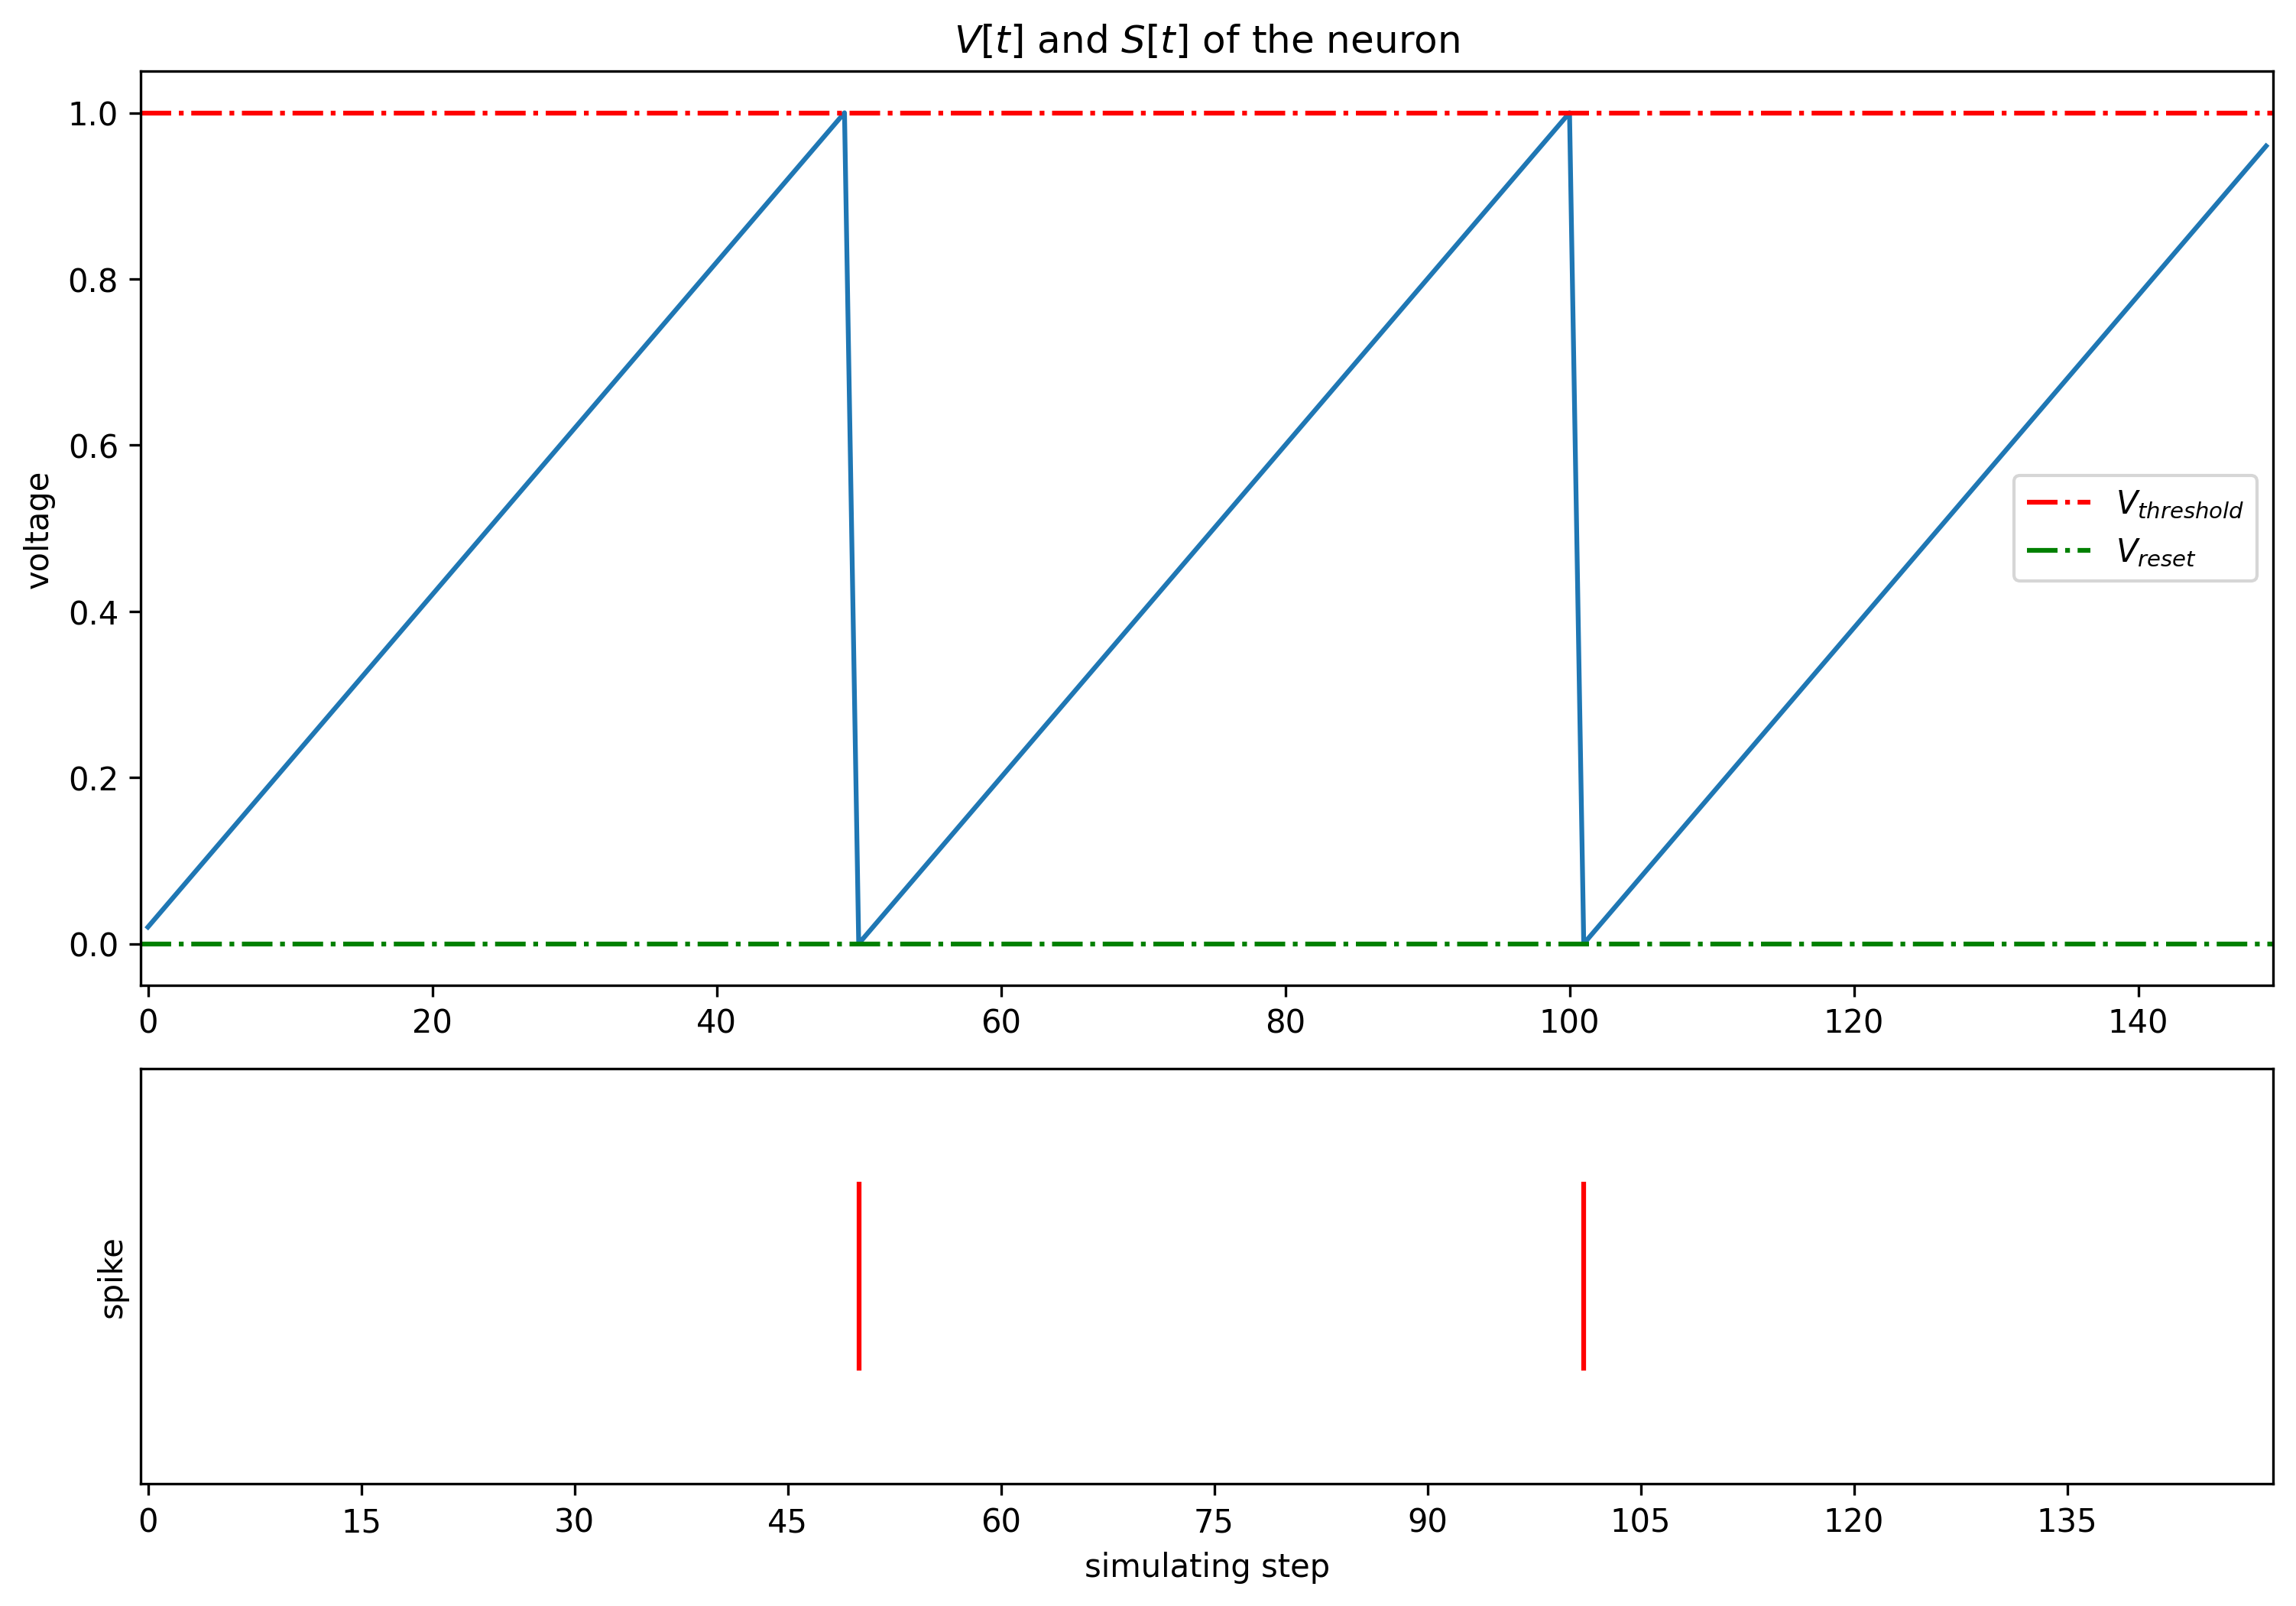

In [2]:
if_layer = neuron.IFNode()

if_layer.reset()
x = torch.as_tensor([0.02])
T = 150
s_list = []
v_list = []
for t in range(T):
    s_list.append(if_layer(x))
    v_list.append(if_layer.v)

dpi = 300
figsize = (12, 8)
visualizing.plot_one_neuron_v_s(torch.cat(v_list).numpy(), torch.cat(s_list).numpy(), v_threshold=if_layer.v_threshold,
                                v_reset=if_layer.v_reset,
                                figsize=figsize, dpi=dpi)
plt.show()

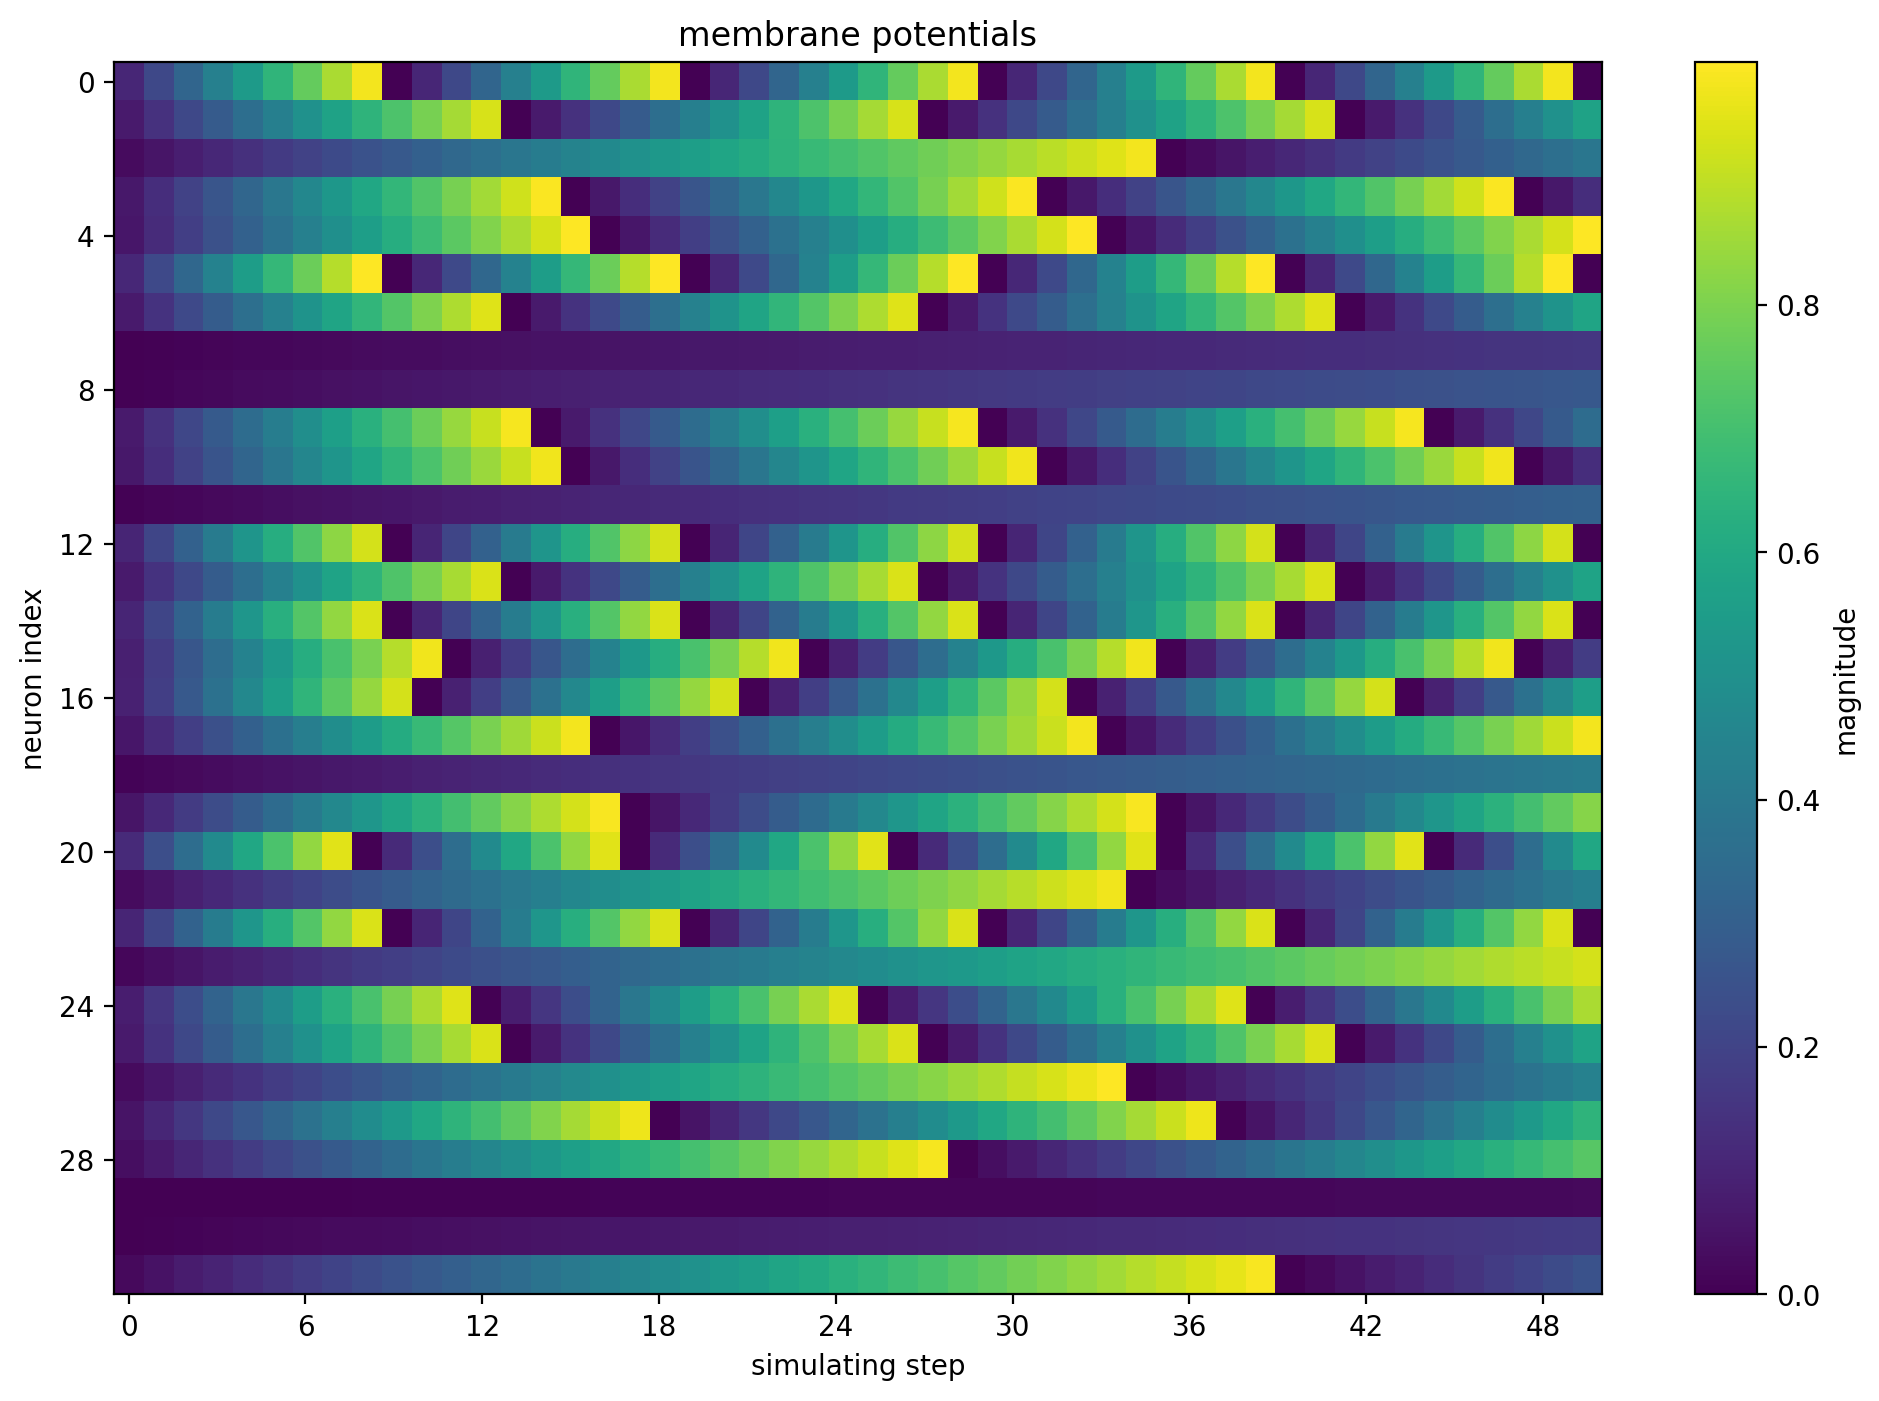

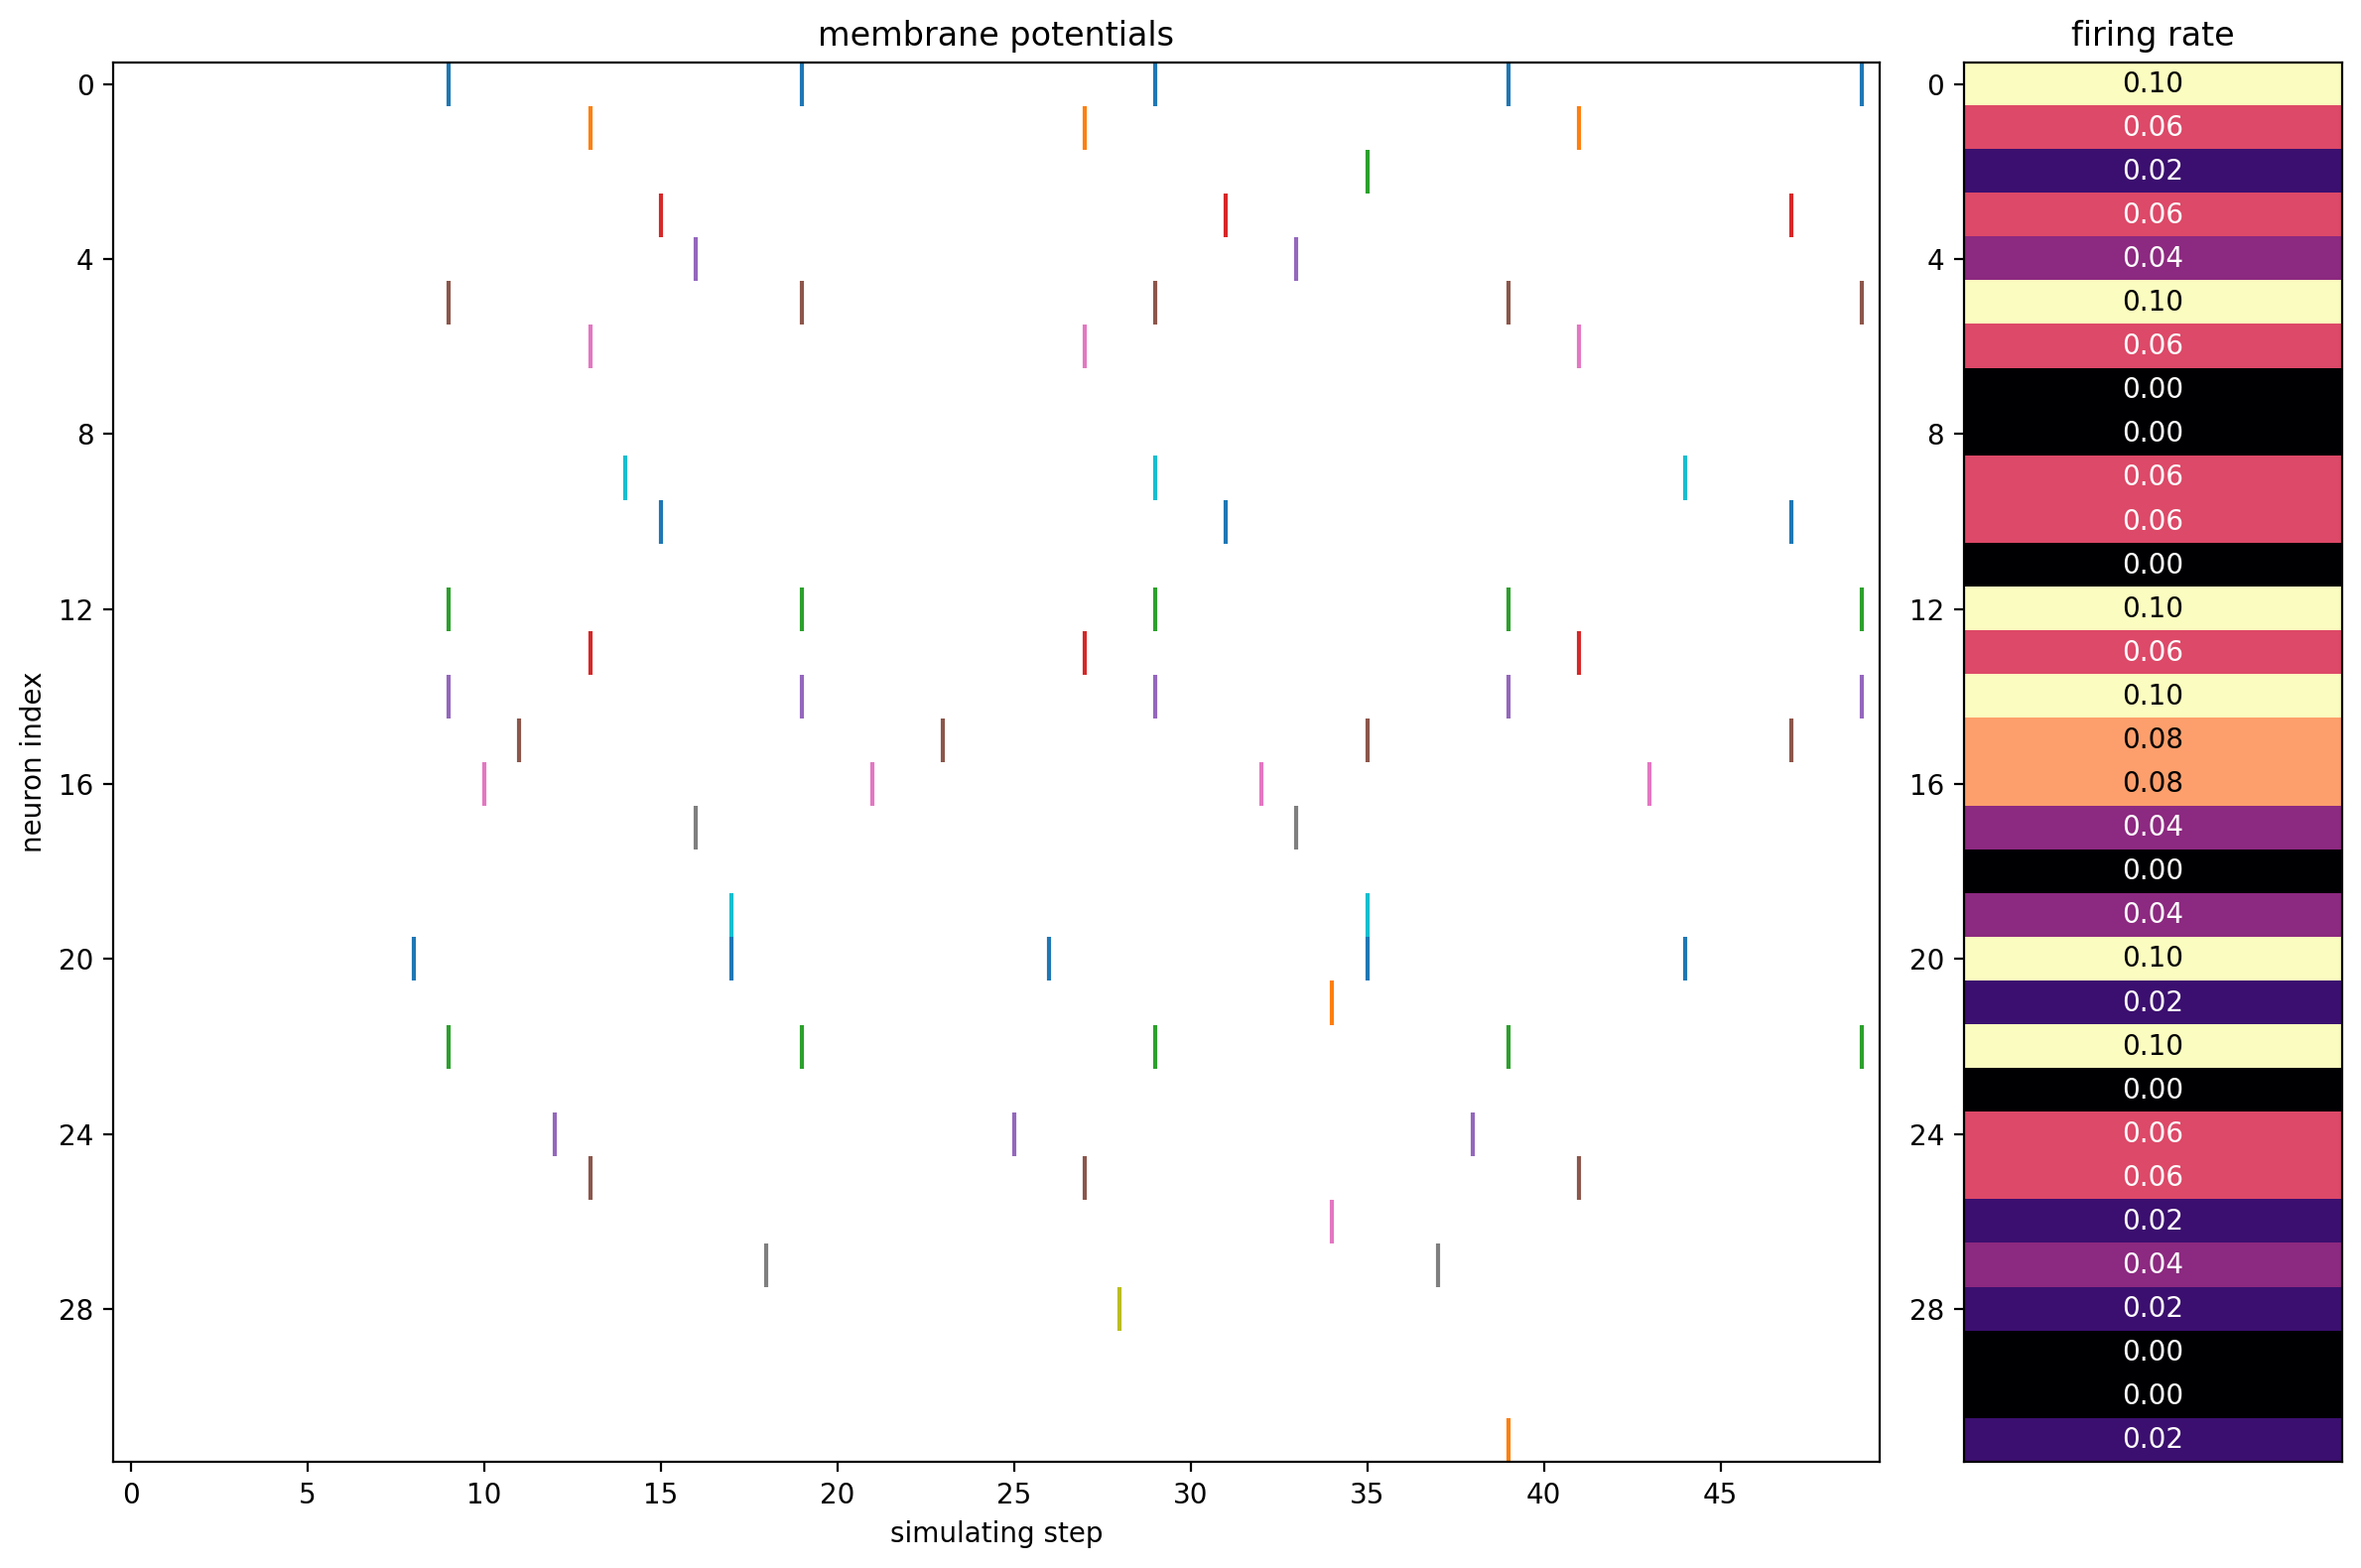

In [ ]:
if_layer.reset()
T = 50
x = torch.rand([32]) / 8.
s_list = []
v_list = []
for t in range(T):
    s_list.append(if_layer(x))
    v_list.append(if_layer.v)

s_array = torch.stack(s_list).numpy() # shape: (T, 32), 32 neurons, 50 time steps

dpi = 200
figsize = (12, 8)
visualizing.plot_2d_heatmap(array=torch.stack(v_list).numpy(), title='membrane potentials', xlabel='simulating step',
                            ylabel='neuron index', int_x_ticks=True, x_max=T, figsize=figsize, dpi=dpi)


visualizing.plot_1d_spikes(spikes=s_array, title='membrane potentials', xlabel='simulating step',
                        ylabel='neuron index', figsize=figsize, dpi=dpi)

plt.show()

### Custom neuron unit

In [ ]:
import torch
import math
from spikingjelly.activation_based import neuron

class LIFNode(neuron.BaseNode):
    def __init__(self, tau=20.0, delta_time=1.0):
        super().__init__()
        self.tau = tau
        self.delta_time = delta_time
        self.beta = torch.exp(-self.delta_time / self.tau)

    def neuronal_charge(self, x):
        self.v = self.beta * self.v + x




class ALIFNode(neuron.BaseNode):
    def __init__(
        self,
        tau: float = 20.0,
        dt: float = 1.0,
        alpha: float = 0.5,
        rho: float = 0.5,
        v_th_base: float = 1.0,
        v_reset: float = 0.0
    ):
        super().__init__()

        self.tau = tau
        self.dt = dt
        self.alpha = alpha
        self.rho = rho
        self.v_th_base = v_th_base
        self.v_reset = v_reset

        self.beta = math.exp(-dt / tau)

        self.register_buffer('v', torch.tensor(0.0))
        self.register_buffer('a', torch.tensor(0.0))
        self.register_buffer('v_th', torch.tensor(v_th_base))
        self.register_buffer('spike', torch.tensor(0.0))

    def neuronal_charge(self, x: torch.Tensor):

        self.v = self.beta * self.v + x - self.spike * self.v_th

        self.a = self.rho * self.a + self.spike
        self.v_th = self.v_th_base + self.alpha * self.a

    def single_step_forward(self, x: torch.Tensor):
        x = x.to(self.v)

        self.neuronal_charge(x)
        self.spike = self.neuronal_fire()
        self.neuronal_reset(self.spike, self.v_reset)
        return self.spike
